In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
# load the arrays from files
images = np.load('/content/drive/MyDrive/Colab Notebooks/images.npy')
masks = np.load('/content/drive/MyDrive/Colab Notebooks/images.npy')

# print(images)
# print(masks)

In [3]:
from sklearn.model_selection import train_test_split

# split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# print the shapes of the training and validation sets
print("Training set - Images:", X_train.shape)
print("Training set - Masks:", y_train.shape)
print("Validation set - Images:", X_val.shape)
print("Validation set - Masks:", y_val.shape)

Training set - Images: (185378, 16, 16, 3)
Training set - Masks: (185378, 16, 16, 3)
Validation set - Images: (46345, 16, 16, 3)
Validation set - Masks: (46345, 16, 16, 3)


# Data Augmentation

In [4]:
# Apply random transformations like rotation, scaling, flipping, or adjusting brightness to augment images and their corresponding masks
# Data augmentation increase the diversity and size of your dataset

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# define the data generator
datagen = ImageDataGenerator(
    rotation_range=20,  # randomly rotate images
    horizontal_flip=True  # randomly flip images horizontally
)

# define the data generator function
def data_generator(images, masks, batch_size):
    num_samples = len(images)
    while True:
        # denerate random indices for the batch
        indices = np.random.choice(num_samples, batch_size, replace=False)
        
        # denerate a batch of images and masks
        batch_images = images[indices]
        batch_masks = masks[indices]
        
        # preprocess the images and masks using the data generator
        batch_images = datagen.flow(batch_images, batch_size=batch_size, shuffle=False).next()
        batch_masks = datagen.flow(batch_masks, batch_size=batch_size, shuffle=False).next()
        
        yield batch_images, batch_masks

# example usage of the data generator
batch_size = 32
generator = data_generator(X_train, y_train, batch_size)


# Model Architecture - U-Net

U-Net architecture using tf.keras. It consists of an encoder and a decoder, where the encoder extracts features and the decoder performs upsampling to generate pixel-level predictions.

In [5]:
def unet_model(input_shape):
    # input layer
    inputs = tf.keras.layers.Input(input_shape)

    # contracting path (Encoder)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # bottom of the UNet
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # expanding path (Decoder)
    up5 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4)
    concat5 = tf.keras.layers.concatenate([up5, conv3], axis=3)
    conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(concat5)
    conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    concat6 = tf.keras.layers.concatenate([up6, conv2], axis=3)
    conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(concat6)
    conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    concat7 = tf.keras.layers.concatenate([up7, conv1], axis=3)
    conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(concat7)
    conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # output layer
    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv7)

    # create the model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

# Dice coefficient

Some hints were found here: https://karan-jakhar.medium.com/100-days-of-code-day-7-84e4918cb72c

In [6]:
def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

# Compilation and training the model

In [7]:
import tensorflow as tf

# TODO: add hyperparam tuning

# define model architecture
model = unet_model(input_shape=(64, 64, 3))

# compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[dice_coefficient])

# define hyperparameters
epochs = 10
batch_size = 32

# create a data generator
train_generator = data_generator(X_train, y_train, batch_size=batch_size)
validation_generator = data_generator(X_val, y_val, batch_size=batch_size)

# train the model using fit_generator
model.fit_generator(generator=train_generator,
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=len(X_val) // batch_size)

Epoch 1/10


<ipython-input-7-d99404f76e42>:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,


5793/5793 [==============================] - 169s 27ms/step - loss: 0.5160 - dice_coefficient: 0.5514 - val_loss: 0.5148 - val_dice_coefficient: 0.5536
Epoch 2/10
5793/5793 [==============================] - 156s 27ms/step - loss: 0.5149 - dice_coefficient: 0.5526 - val_loss: 0.5152 - val_dice_coefficient: 0.5539
Epoch 3/10
5793/5793 [==============================] - 159s 27ms/step - loss: 0.5148 - dice_coefficient: 0.5536 - val_loss: 0.5146 - val_dice_coefficient: 0.5543
Epoch 4/10
5793/5793 [==============================] - 158s 27ms/step - loss: 0.5150 - dice_coefficient: 0.5528 - val_loss: 0.5148 - val_dice_coefficient: 0.5482
Epoch 5/10
5793/5793 [==============================] - 159s 27ms/step - loss: 0.5146 - dice_coefficient: 0.5529 - val_loss: 0.5135 - val_dice_coefficient: 0.5502
Epoch 6/10
5793/5793 [==============================] - 159s 27ms/step - loss: 0.5142 - dice_coefficient: 0.5539 - val_loss: 0.5142 - val_dice_coefficient: 0.5507
Epoch 7/10
5793/5793 [===========

In [8]:
# save best model
from google.colab import drive

# drive.mount('/gdrive') 
drive.mount('/content/drive')
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/airbus'

model.save(f'{BASE_PATH}/model')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


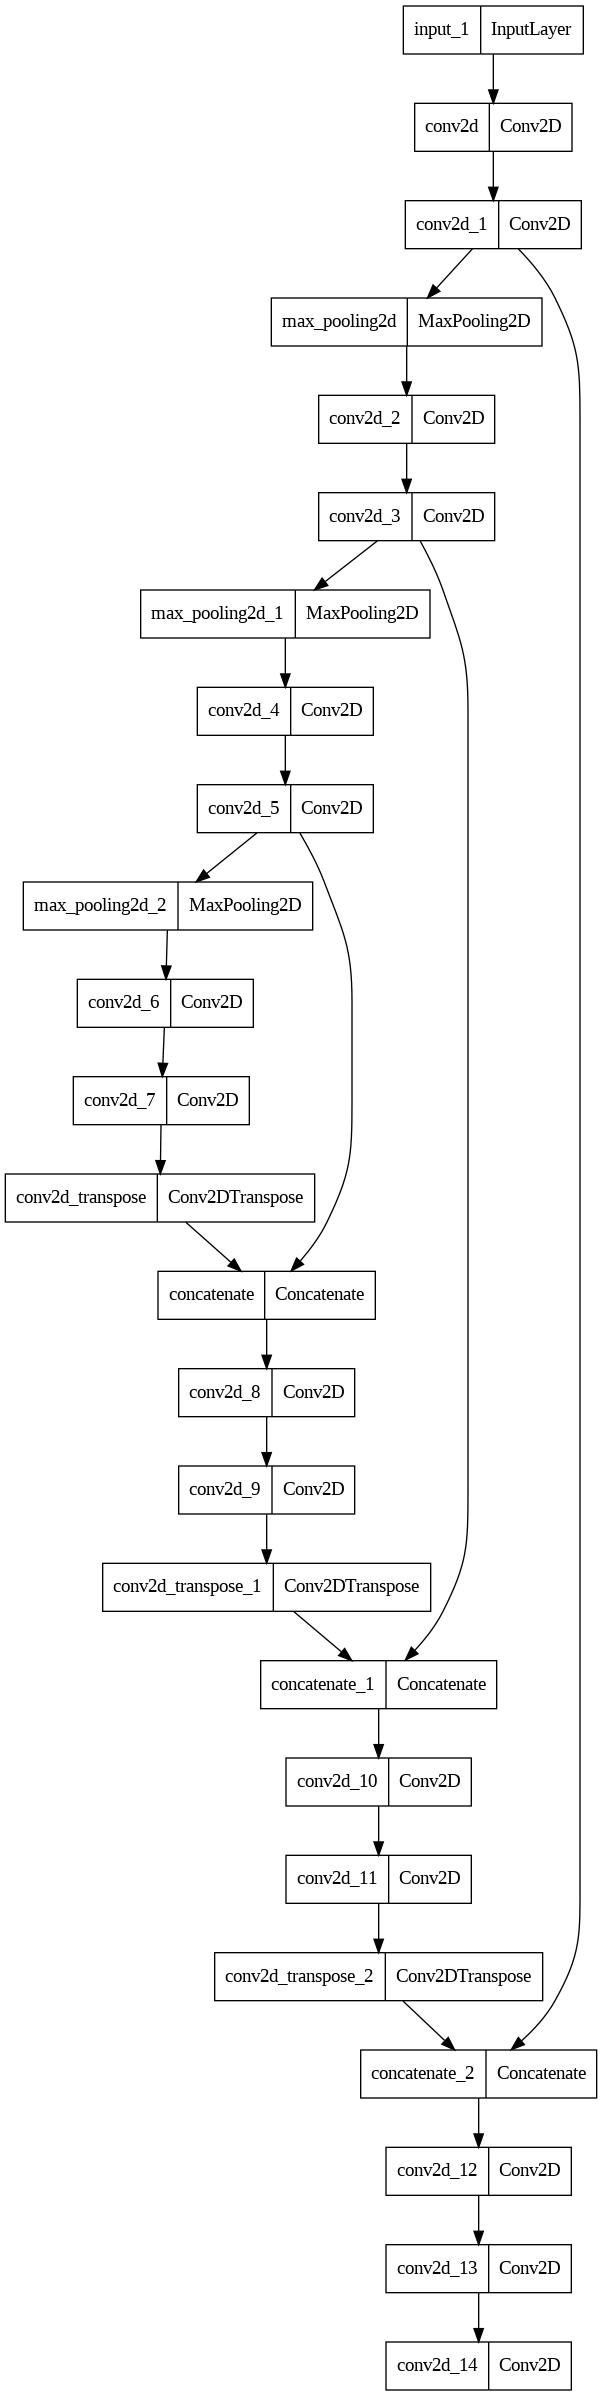

In [9]:
tf.keras.utils.plot_model(model, "model.png")

Error loading image .ipynb_checkpoints: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 [==============================] - 0s 210ms/step


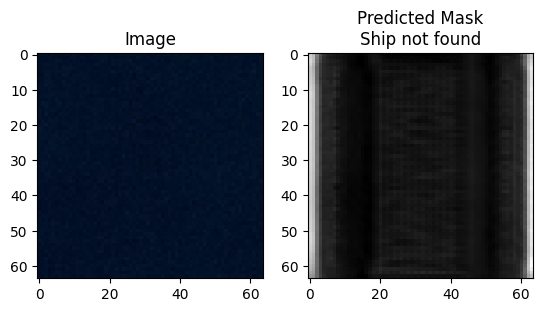

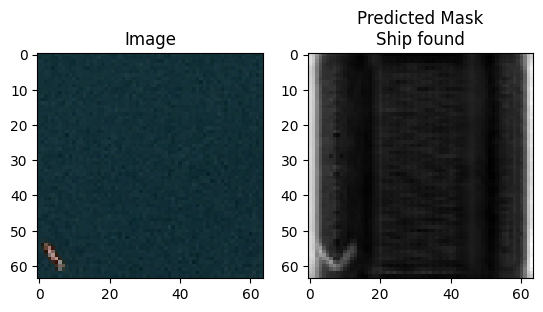

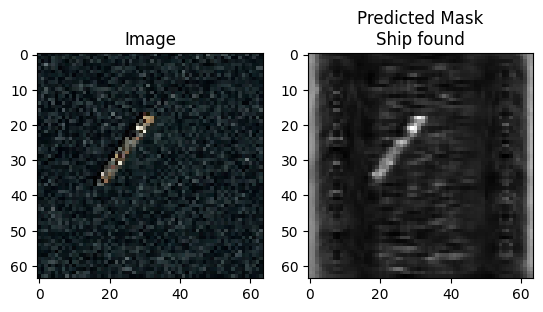

In [18]:
# path to the folder containing test images
test_folder = '/content/drive/MyDrive/Colab Notebooks/airbus/test/'

# get the list of image files in the folder
image_files = os.listdir(test_folder)

# read and load test images
test_images = []
for image_file in image_files:
    image_path = os.path.join(test_folder, image_file)
    try:
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, (64, 64))
        test_images.append(resized_image)
    except Exception as e:
        print(f"Error loading image {image_file}: {str(e)}")
        
# normalize pixel values
normalized_images = np.array(test_images) / 255.0

# make predictions
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/airbus/model', custom_objects={'dice_coefficient': dice_coefficient})
predicted_masks = model.predict(normalized_images)

# define a threshold to determine ship presence
threshold = 0.4
## TODO: add function to create Encoded Pixels from mask images

# display images and predicted masks
for i in range(len(test_images)):
    # apply thresholding to create a binary mask
    binary_mask = np.where(predicted_masks[i].squeeze() > threshold, 1, 0)

    # check if any pixel in the binary mask is white (indicating the presence of a ship)
    if np.any(binary_mask == 1):
        result = "Ship found"
    else:
        result = "Ship not found"
    
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(test_images[i], cv2.COLOR_BGR2RGB))
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_masks[i].squeeze(), cmap='gray')
    plt.title(f'Predicted Mask\n{result}')

    plt.show()